## Xマッチからブキ偏差値を求める

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 8)
date_to = dt.date(2023, 6, 14)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 7119


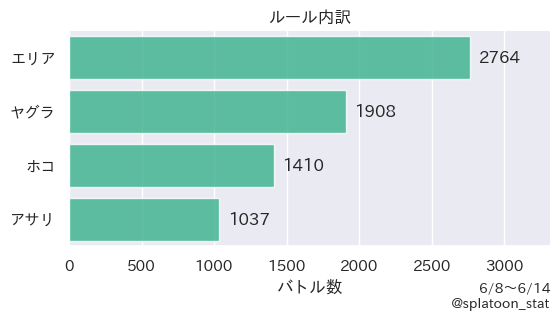

パワー不明バトル数: 831


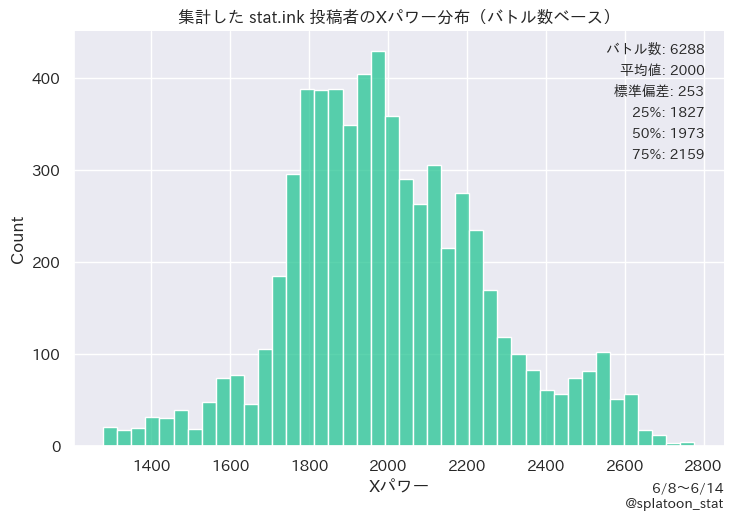

In [2]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [3]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [4]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
power = players.groupby(["mode", "weapon"])["power"].mean().to_frame("power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = weapon_stat.groupby("mode")["usage"].transform(lambda x: boxcox(x)[0])
weapon_stat["usage-z"] = weapon_stat.groupby("mode", group_keys=False)["usage-bc"].apply(standardize)
weapon_stat["power-z"] = weapon_stat.groupby("mode", group_keys=False)["power"].apply(standardize)

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
weapon_stat

usage        power  usage-bc   usage-z  \
mode   weapon                                                            
area   sshooter_collabo      0.052770  1920.040622 -2.195543  2.141787   
       sharp_neo             0.046671  1999.408364 -2.260977  1.982251   
       spaceshooter_collabo  0.042382  2012.511201 -2.311179  1.859852   
       wakaba                0.041245  1932.074095 -2.325157  1.825773   
       sharp                 0.040469  2056.481869 -2.334863  1.802110   
...                               ...          ...       ...       ...   
yagura wideroller            0.000898  1944.433333 -3.629559 -1.551980   
       rapid_elite           0.000599  1836.616667 -3.715993 -1.776513   
       l3reelgun             0.000449  2089.550000 -3.772923 -1.924402   
       carbon                0.000374  1895.000000 -3.807228 -2.013518   
       h3reelgun             0.000374  1970.350000 -3.807228 -2.013518   

                              power-z  strength  strength-z  strength-t  
mode   weapon                                                            
area   sshooter_collabo     -0.811457  1.101628    1.079810   60.798100  
       sharp_neo             0.223767  1.652641    1.619910   66.199102  
       spaceshooter_collabo  0.394673  1.670562    1.637477   66.374766  
       wakaba               -0.654500  0.963265    0.944188   59.441876  
       sharp                 0.968200  1.999130    1.959537   69.595373  
...                               ...       ...         ...         ...  
yagura wideroller           -1.132063 -1.915351   -1.877417   31.225828  
       rapid_elite          -2.977079 -3.284330   -3.219283   17.807166  
       l3reelgun             1.351250 -0.585760   -0.574159   44.258414  
       carbon               -1.977993 -2.815694   -2.759930   22.400705  
       h3reelgun            -0.688563 -1.978277   -1.939097   30.609027  

[360 rows x 8 columns]

### 可視化する

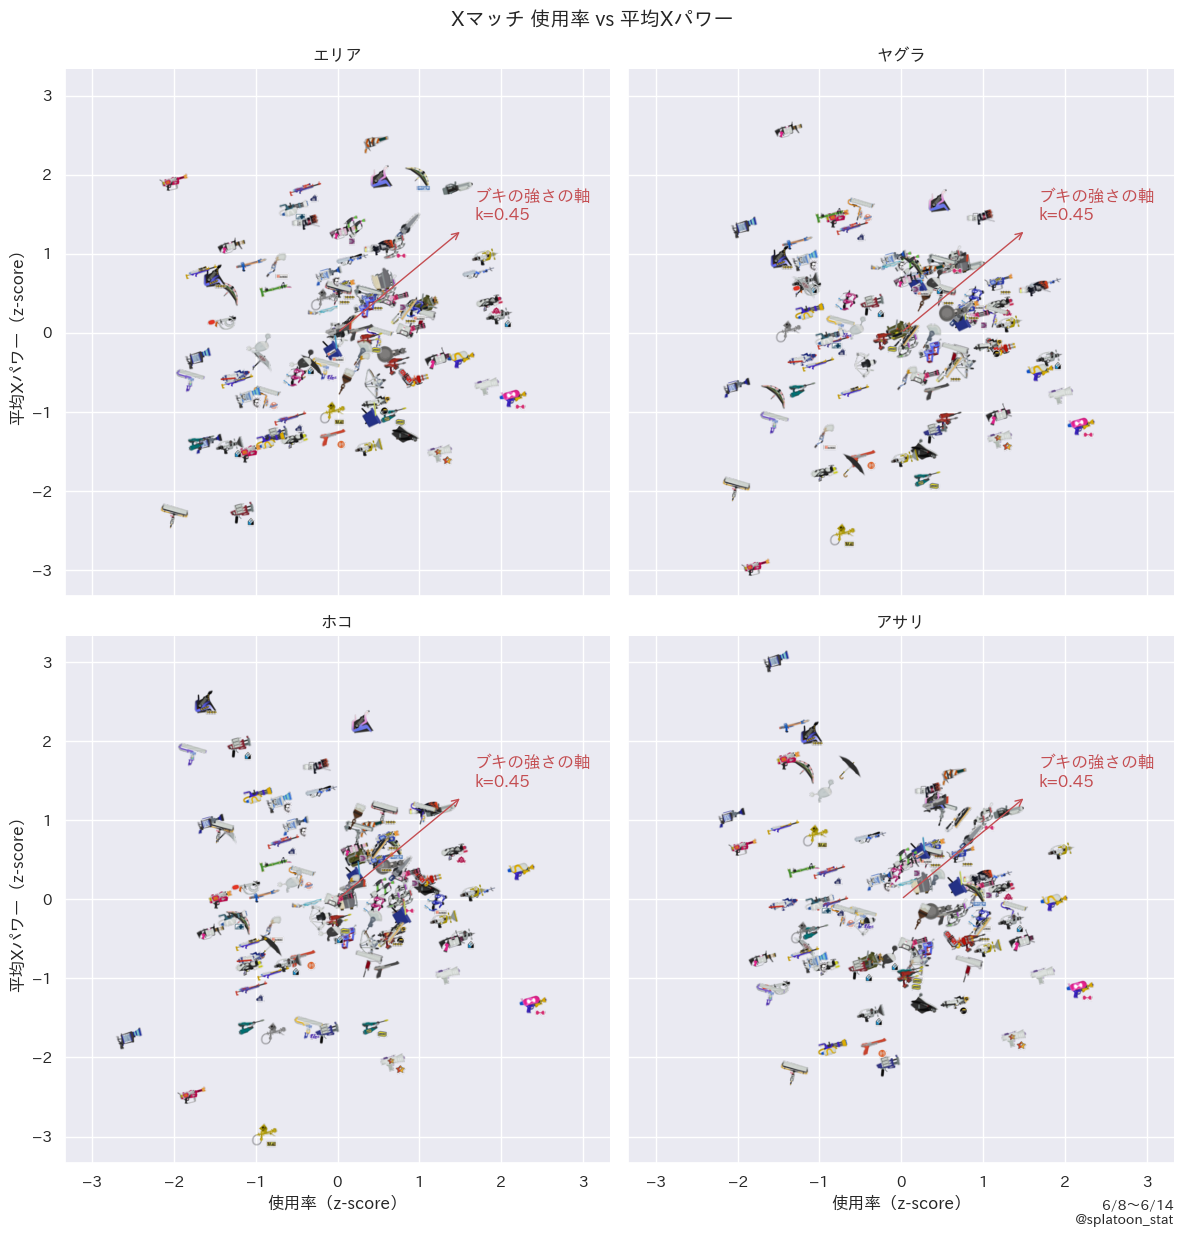

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均Xパワー（z-score）", "X Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均Xパワー", "Usage vs X Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=6,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.set(
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for _, row in weapon_stat.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["usage-z"]
        yvalue = row["power-z"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    # ブキの強さの軸のベクトルを表示する
    ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

In [6]:
strength_map = weapon_stat.reset_index().pivot(index="weapon", columns="mode", values="strength-t").reindex(d.MODE_ORDER, axis=1)
strength_map["mean"] = strength_map.mean(axis=1)
strength_map = strength_map.sort_values("mean", ascending=False)
strength_map


mode,area,yagura,hoko,asari,mean
weapon,,,,,
kugelschreiber,72.689681,61.584169,66.612427,66.875551,66.940457
sharp,69.595373,60.599354,62.982307,68.576321,65.438339
liter4k,67.603523,67.055863,63.426949,60.440664,64.631750
bucketslosher,66.488281,64.010194,66.399029,61.135473,64.508244
spaceshooter_collabo,66.374766,61.421744,64.523214,60.052947,63.093168
...,...,...,...,...,...
promodeler_rg,43.182851,28.441651,24.456206,47.411248,35.872989
wideroller,32.727184,31.225828,48.538211,30.401466,35.723172
jetsweeper,28.925830,36.526164,32.054582,39.746117,34.313173


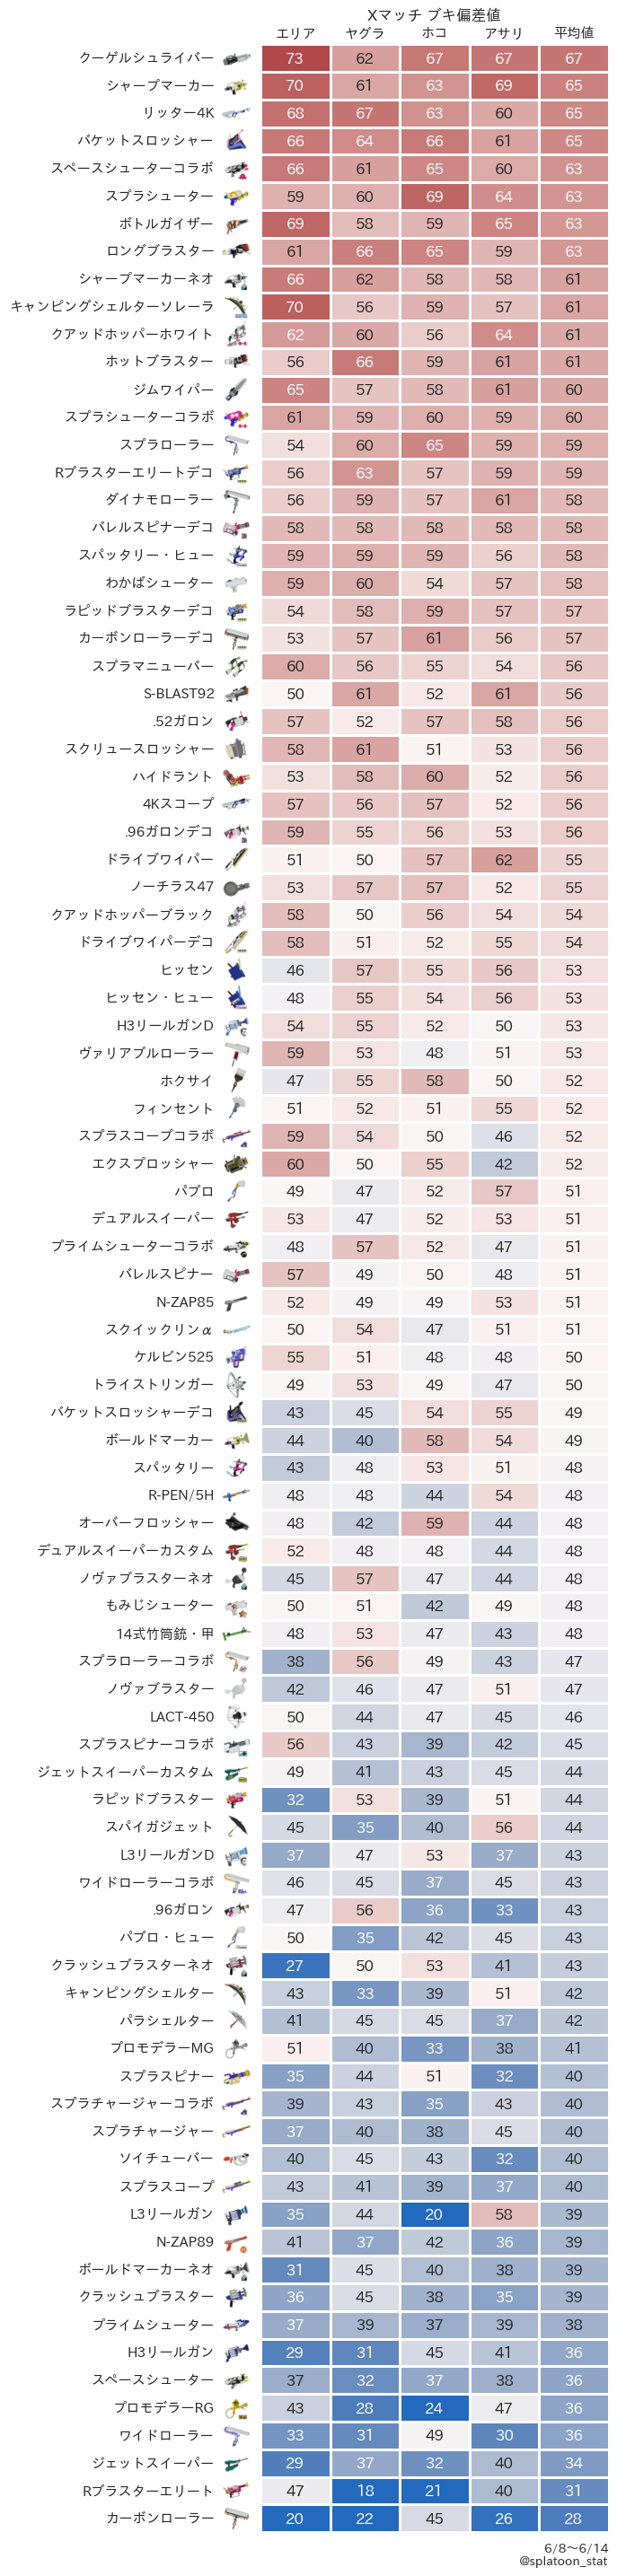

In [7]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

fig, ax = plt.subplots(figsize=(5, len(strength_map.index) * 0.4))
sns.heatmap(
    strength_map,
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=50,
    vmin=50-25,
    vmax=50+25,
    linewidths=2,
    ax=ax,
)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.35, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_data_duration(battles), .3)

plt.show()